In [5]:
from pymilvus.model.hybrid import BGEM3EmbeddingFunction  
import base64
def encode_image(image_path):  
    with open(image_path, "rb") as image_file:  
        return base64.b64encode(image_file.read()).decode("utf-8")  


/home/zhuyao/anaconda3/envs/benchmarkllava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import json
with open("/home/zhuyao/Sunpeng/llava_qwen/data/rag/data.json", "r") as f:
    data = json.load(f)

In [7]:
data[0]

{'filename': '000317dc-9047-4d68-bb55-e40c09ed0f9a.jpg',
 'content': '这个表情包展示了两只水豚，它们的表情看起来很是严肃，甚至有些不悦。图片的笑点在于它们的表情和图片上的文字“孤立他”，这种不匹配产生了幽默效果。通常，这样的表情包被用来幽默地表达对某人或某事的不满或反对，通过这种方式，可以轻松地在社交媒体上表达情绪，同时也能引发他人的共鸣和笑声。'}

In [8]:
import os
img_base64_list = [encode_image(os.path.join("/home/zhuyao/Sunpeng/llava_qwen/data/rag/emo",dp["filename"])) for dp in data[:300]]  
image_summaries = [dp["content"] for dp in data[:300]]  

In [9]:
from langchain.schema import Document 
documents = [Document(page_content=image_summaries[i], metadata={"source": img_base64_list[i]}) for i in range (len(image_summaries))]  


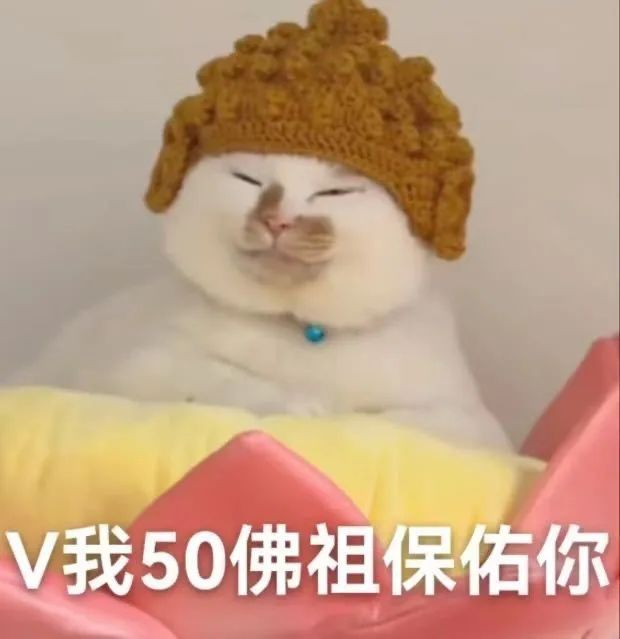

这个表情包中的内容和笑点在于它展示了一只戴着类似佛像帽子的猫咪，下方的文字“V我50佛祖保佑你”是一种幽默的表达方式。这句话用了网络流行语，是一种俏皮的请求方式，仿佛这只猫咪在以一种幽默的方式请求别人给它转账50元，并承诺相应的好运或保佑。这种将宠物赋予人类化特征和宗教元素的结合，以及使用网络流行语的创意，使得这个表情包既可爱又有趣。


In [10]:
from IPython.display import HTML, display  
def plt_img_base64(img_base64):  
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'  
    display(HTML(image_html))  
  
   
index = 7
plt_img_base64(img_base64_list[index])  
print(image_summaries[index])  

In [11]:
from langchain.embeddings.base import Embeddings  
class BGEMilvusEmbeddings(Embeddings):  
  
    def __init__(self):  
  
        self.model = BGEM3EmbeddingFunction(  
                    model_name='BAAI/bge-m3',
                    device='cpu', 
                    use_fp16=False 
  
                )  
  
    def embed_documents(self, texts):  
        embeddings = self.model.encode_documents(texts)  
        return [i.tolist() for i in embeddings["dense"]]  
  
    def embed_query(self, text):  
        embedding = self.model.encode_queries([text])  
        return embedding["dense"][0].tolist()  

In [12]:
# initialize
from langchain_milvus.vectorstores import Milvus  
embedding_model = BGEMilvusEmbeddings()  
URI = "./milvus_emo.db"  
  
vectorstore = Milvus.from_documents(  
    documents,  
    embedding_model,
    connection_args={"uri": URI},
    collection_name="multimodal_rag_demo"  
)  
retriever = vectorstore.as_retriever()  

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 121691.61it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


In [ ]:
# load
# from langchain_milvus import Milvus
# from langchain_openai import OpenAIEmbeddings

# URI = "/home/zhuyao/Sunpeng/llava_qwen/RAG/milvus_emo.db"  

# vector_store = Milvus(
#     embedding_function=embedding_model,
#     collection_name="multimodal_rag_demo",
#     connection_args={"uri": URI},
# )
# retriever = vector_store.as_retriever()  


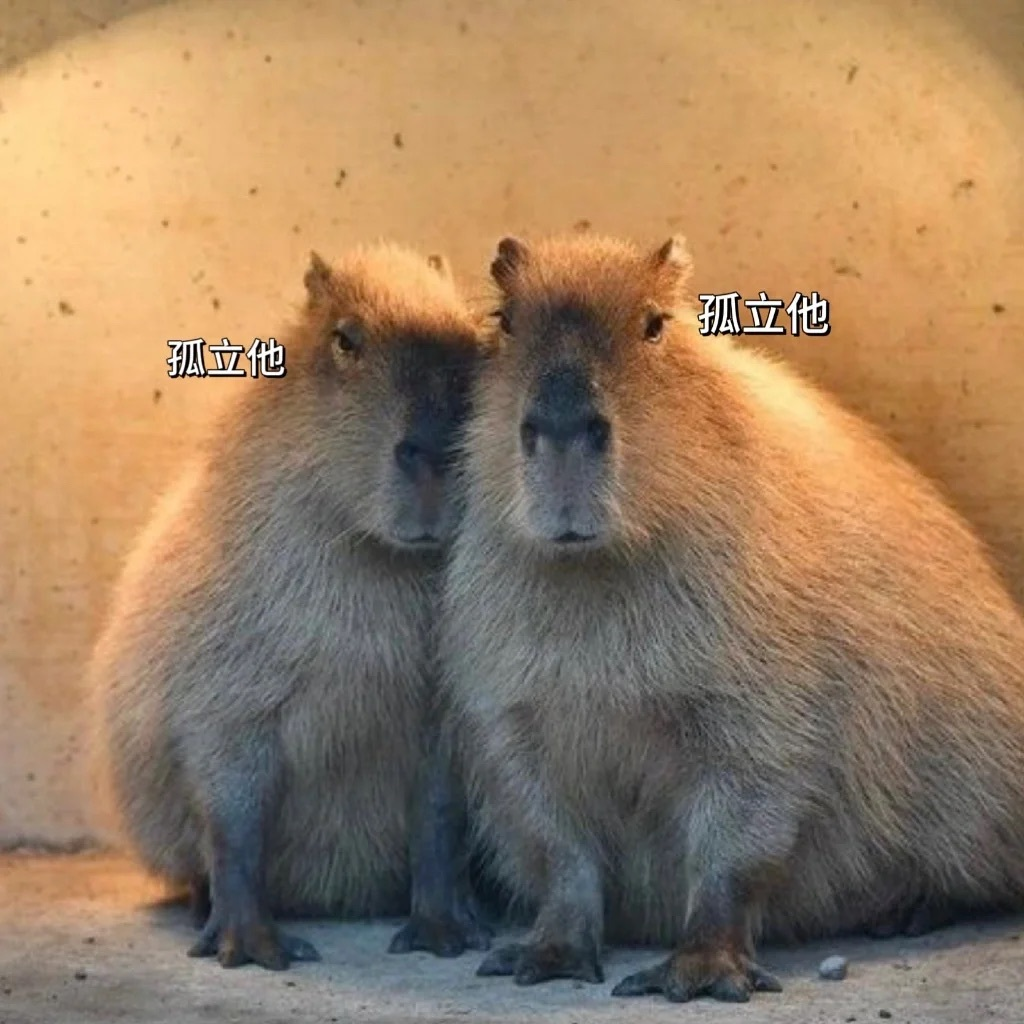

In [ ]:
query = "水豚孤立。"  
retrieved_docs = retriever.invoke(query, limit= 1)  
plt_img_base64(retrieved_docs[0].metadata["source"])  

In [ ]:
retriever.invoke(query, limit= 1)[0].metadata["source"] 

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQIBAQICAgICAgICAwUDAwMDAwYEBAMFBwYHBwcGBwcICQsJCAgKCAcHCg0KCgsMDAwMBwkODw0MDgsMDAz/2wBDAQICAgMDAwYDAwYMCAcIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCAQABAADASIAAhEBAxEB/8QAHgAAAgIDAQEBAQAAAAAAAAAABAUDBgECBwgACQr/xABfEAABAwMCAwYCBwQIBAQAAhsCAQMEAAURBhITITEHFCIyQVFCYQgVI1JxgZEzYqGxCRYkcsHR4fFDgqLwChc0kiVTssIYRGNU0iYnNUVzdIOFltPyRlVkZoS0xNTi/8QAHAEAAgMBAQEBAAAAAAAAAAAAAgMAAQQFBgcI/8QANBEAAgICAgICAgICAAQGAgMAAAECEQMhBDESQRNRBSIGYRQyFUJScQcWI4GRodHhNLHx/9oADAMBAAIRAxEAPwC6q9xvTFV1m2uldvLT5qOXrULxcP518Mf7H1JM+4a7kHrUcpn5VM2W7ntoOc26UjLfhqLspdkrbfDrZ0dorWrbL4iil4hrU3k21bVPZdbC4MPiRRrdLft/5q3sryCxzGiO9IXUaZGVEasSymeFKVKw2222uE8JFU1ykI44vh81IJVzNuQQp6U7z+xDg3IekKNjkRqAWVN7fjzVvabwxLZBHC2mPLC0a42JCKj4kL1p66LkrFExrc5uoSUKE3TK5RVHfj4qVuM/vVYEoNgws+KhG9MvS53FzgKbw2dw5822iY4k5yAelN+XVCbRCL3c20bWteNxFylM2NKvTtpKNN7b2euuDnZWbJmo1QjZT3Lecpwdg1LH06/I8Hl3fu10m16B4YoqoO7220aGnRbc2oArikPksKeHyOa2vs7kFOEi2l/y07naF2u7sjXRIdmEmRRU21I5YQc6Ut5